**Ник на kaggle: [netkex](https://www.kaggle.com/netkex)**

**Результат на kaggle: 0.99787** 


In [ ]:
import torch
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary

from matplotlib import colors, pyplot as plt
%matplotlib inline

import imutils
import cv2
from google.colab.patches import cv2_imshow
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torchvision.transforms.functional as F
import random
from typing import Sequence

import time

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

### Загрузка данных + балансировка

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip -q /content/gdrive/My\ Drive/dl_course/simpsons/data/testset.zip -d test

In [ ]:
!unzip -q /content/gdrive/My\ Drive/dl_course/simpsons/data/train.zip -d train

In [ ]:
TRAIN_DIR = Path('train/train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
all_labels = set(train_val_labels)
all_labels

{'abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers'}

In [ ]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
def count_file_stats(train_files):
  char_train_cnt = {}
  char_train_lst = {}
  for character in all_labels: 
      char_train_cnt[character] = 0
      char_train_lst[character] = []

  for file in train_files:
      char_train_cnt[file.parent.name] += 1
      char_train_lst[file.parent.name].append(file)
  return char_train_cnt, char_train_lst

char_train_cnt, char_train_lst = count_file_stats(train_files)
print(''.join('{}: {}\n'.format(k,v) for k,v in char_train_cnt.items()))

kent_brockman: 373
lenny_leonard: 233
bart_simpson: 1006
lionel_hutz: 2
fat_tony: 20
edna_krabappel: 343
principal_skinner: 895
mayor_quimby: 185
milhouse_van_houten: 809
chief_wiggum: 739
rainier_wolfcastle: 34
professor_john_frink: 49
cletus_spuckler: 35
nelson_muntz: 269
comic_book_guy: 352
miss_hoover: 13
ralph_wiggum: 67
patty_bouvier: 54
waylon_smithers: 136
charles_montgomery_burns: 895
barney_gumble: 80
snake_jailbird: 41
groundskeeper_willie: 91
krusty_the_clown: 904
marge_simpson: 968
ned_flanders: 1090
disco_stu: 6
agnes_skinner: 32
martin_prince: 53
carl_carlson: 74
gil: 20
lisa_simpson: 1015
otto_mann: 24
troy_mcclure: 6
sideshow_mel: 30
homer_simpson: 1684
maggie_simpson: 96
moe_szyslak: 1089
abraham_grampa_simpson: 685
sideshow_bob: 658
apu_nahasapeemapetilon: 467
selma_bouvier: 77



In [ ]:
little_class_border = 150

In [ ]:
for k, file_lst in char_train_lst.items(): 
    if (char_train_cnt[k] >= little_class_border):
      continue
    random_files = torch.randint(0, char_train_cnt[k], 
                            (little_class_border - char_train_cnt[k],))
    for i in random_files: 
        train_files.append(char_train_lst[k][i])

train_cnt_upd, _ = count_file_stats(train_files)
print(''.join('{}: {}\n'.format(k,v) for k, v in train_cnt_upd.items()))

kent_brockman: 373
lenny_leonard: 233
bart_simpson: 1006
lionel_hutz: 150
fat_tony: 150
edna_krabappel: 343
principal_skinner: 895
mayor_quimby: 185
milhouse_van_houten: 809
chief_wiggum: 739
rainier_wolfcastle: 150
professor_john_frink: 150
cletus_spuckler: 150
nelson_muntz: 269
comic_book_guy: 352
miss_hoover: 150
ralph_wiggum: 150
patty_bouvier: 150
waylon_smithers: 150
charles_montgomery_burns: 895
barney_gumble: 150
snake_jailbird: 150
groundskeeper_willie: 150
krusty_the_clown: 904
marge_simpson: 968
ned_flanders: 1090
disco_stu: 150
agnes_skinner: 150
martin_prince: 150
carl_carlson: 150
gil: 150
lisa_simpson: 1015
otto_mann: 150
troy_mcclure: 150
sideshow_mel: 150
homer_simpson: 1684
maggie_simpson: 150
moe_szyslak: 1089
abraham_grampa_simpson: 685
sideshow_bob: 658
apu_nahasapeemapetilon: 467
selma_bouvier: 150



### DataSet

In [ ]:
names_encoder = LabelEncoder()
names_encoder.fit(list(all_labels));

In [ ]:
def show_img_filepath(filepath): 
    image = cv2.imread(str(filepath))
    cv2_imshow(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
class RotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return F.rotate(x, angle)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, label_encoder, 
                 rotate_flag=True):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.rotate_flag = rotate_flag

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = label_encoder
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
                      
    def __len__(self):
        return self.len_
      
    def load_image(self, file):
        image = Image.open(file)
        image.load()
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            if self.rotate_flag:
                transform = transforms.Compose([
                  transforms.RandomHorizontalFlip(),
                  RotateTransform([-90, 0, 0, 90]),
                  transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 3)),
                  transforms.RandomAdjustSharpness(sharpness_factor=4),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
                ])
            else:
                transform = transforms.Compose([
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
                ])
        else: 
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_image(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', label_encoder=names_encoder)    
train_dataset = SimpsonsDataset(train_files, mode='train', label_encoder=names_encoder)

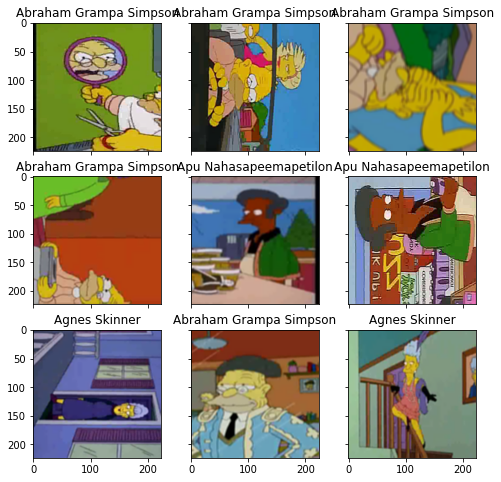

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    idd = idd + 1
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

#### Модель и обучение

In [ ]:
n_classes = len(np.unique(train_val_labels))
n_classes

42

In [ ]:
model_vgg = models.vgg19_bn(pretrained=True)

features_to_unfreeze = 23

num_features = 25088

for param in model_vgg.features[:-features_to_unfreeze].parameters():
    param.requires_grad = False

model_vgg.classifier = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.65, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=4096, out_features=n_classes, bias=True)
)

model_vgg = model_vgg.to(DEVICE)

print(model_vgg, model_vgg.features.parameters())

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
def save_model(model, version_num):
    torch.save(model.state_dict(), 'model_version' + str(version_num) + '.pth')

In [ ]:
def download_model(model, file): 
    model.load_state_dict(torch.load(file))

In [ ]:
download_model(model_vgg, 'model_version3_1.pth')

##### Обучение

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_pred = np.array([])
    answers = np.array([])
    running_accuracy = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader, desc=f"iter:"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_pred = np.hstack((running_pred, preds.cpu().numpy().flatten()))
        answers = np.hstack((answers, labels.cpu().numpy().flatten()))
        running_accuracy += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_accuracy.cpu().numpy() / processed_data
    train_f1 = f1_score(running_pred, answers, average='weighted')
    return train_loss, train_acc, train_f1

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_pred = np.array([])
    answers = np.array([])
    running_accuracy = 0
    processed_data = 0

    for inputs, labels in tqdm(val_loader, desc=f"iter:"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_pred = np.hstack((running_pred, preds.cpu().numpy().flatten()))
        answers = np.hstack((answers, labels.cpu().numpy().flatten()))
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    val_loss = running_loss / processed_data
    val_acc = running_accuracy.cpu().numpy() / processed_data
    val_f1 = f1_score(running_pred, answers, average='weighted')
    return val_loss, val_acc, val_f1

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, num_workers_, lr_=3e-4):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_)
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} \n\
    train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} \n\
    train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"

    opt = torch.optim.AdamW(model.parameters(), lr=lr_)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        if (epoch % 10 == 0) and (epoch != 0):
            opt.param_groups[0]['lr'] = opt.param_groups[0]['lr'] / 10
        train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, opt)
        print("loss", train_loss)
        
        val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))
        
        print(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        v_loss=val_loss, t_acc=train_acc, v_acc=val_acc,
                                        t_f1=train_f1, v_f1=val_f1))
            
    return history

In [ ]:
torch.cuda.empty_cache()
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
history1 = train(train_dataset, val_dataset, model=model_vgg, epochs=7, batch_size=128, num_workers_=6)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:30<00:00,  2.35s/it]


loss 1.6462714142719457


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.65s/it]



Epoch 001 train_loss: 1.6463     val_loss 0.6331 
    train_acc 0.5689 val_acc 0.8384 
    train_f1 0.6089 val_f1 0.8539


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:29<00:00,  2.34s/it]


loss 0.5289275452317889


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.66s/it]



Epoch 002 train_loss: 0.5289     val_loss 0.4004 
    train_acc 0.8577 val_acc 0.8957 
    train_f1 0.8612 val_f1 0.8953


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:28<00:00,  2.33s/it]


loss 0.2960002946391643


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.65s/it]



Epoch 003 train_loss: 0.2960     val_loss 0.3759 
    train_acc 0.9218 val_acc 0.9033 
    train_f1 0.9223 val_f1 0.8992


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:28<00:00,  2.33s/it]


loss 0.2334012830368268


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.64s/it]



Epoch 004 train_loss: 0.2334     val_loss 0.3086 
    train_acc 0.9384 val_acc 0.9266 
    train_f1 0.9386 val_f1 0.9250


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:27<00:00,  2.33s/it]


loss 0.18548237702181944


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.65s/it]



Epoch 005 train_loss: 0.1855     val_loss 0.2822 
    train_acc 0.9525 val_acc 0.9257 
    train_f1 0.9526 val_f1 0.9238


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:29<00:00,  2.34s/it]


loss 0.1577460999578342


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.64s/it]



Epoch 006 train_loss: 0.1577     val_loss 0.3596 
    train_acc 0.9583 val_acc 0.9115 
    train_f1 0.9583 val_f1 0.9057


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:29<00:00,  2.34s/it]


loss 0.14716599174675668


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.65s/it]


Epoch 007 train_loss: 0.1472     val_loss 0.2915 
    train_acc 0.9625 val_acc 0.9356 
    train_f1 0.9625 val_f1 0.9366


In [ ]:
# Reconstruct train_dataset and val_dataset

In [ ]:
history2 = train(train_dataset, val_dataset, model=model_vgg, epochs=10, batch_size=128, num_workers_=6, lr_=0.0001)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:39<00:00,  2.41s/it]


loss 0.05091561447306069


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.66s/it]



Epoch 001 train_loss: 0.0509     val_loss 0.0592 
    train_acc 0.9875 val_acc 0.9878 
    train_f1 0.9875 val_f1 0.9877


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:38<00:00,  2.40s/it]


loss 0.04159884463451806


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:08<00:00,  1.67s/it]



Epoch 002 train_loss: 0.0416     val_loss 0.0564 
    train_acc 0.9898 val_acc 0.9882 
    train_f1 0.9898 val_f1 0.9881


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:39<00:00,  2.41s/it]


loss 0.030861569395411938


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:08<00:00,  1.66s/it]



Epoch 003 train_loss: 0.0309     val_loss 0.0664 
    train_acc 0.9913 val_acc 0.9870 
    train_f1 0.9913 val_f1 0.9869


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:38<00:00,  2.40s/it]


loss 0.030437135942769006


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.66s/it]



Epoch 004 train_loss: 0.0304     val_loss 0.0660 
    train_acc 0.9917 val_acc 0.9872 
    train_f1 0.9917 val_f1 0.9870


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:38<00:00,  2.40s/it]


loss 0.030037412423441563


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.65s/it]



Epoch 005 train_loss: 0.0300     val_loss 0.0670 
    train_acc 0.9918 val_acc 0.9876 
    train_f1 0.9918 val_f1 0.9876


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:39<00:00,  2.41s/it]


loss 0.02245438290794718


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:08<00:00,  1.67s/it]



Epoch 006 train_loss: 0.0225     val_loss 0.0585 
    train_acc 0.9944 val_acc 0.9880 
    train_f1 0.9944 val_f1 0.9879


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:39<00:00,  2.41s/it]


loss 0.022740895748648196


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:08<00:00,  1.66s/it]



Epoch 007 train_loss: 0.0227     val_loss 0.0617 
    train_acc 0.9943 val_acc 0.9872 
    train_f1 0.9943 val_f1 0.9871


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:38<00:00,  2.40s/it]


loss 0.02018132354761094


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:08<00:00,  1.66s/it]



Epoch 008 train_loss: 0.0202     val_loss 0.0682 
    train_acc 0.9945 val_acc 0.9866 
    train_f1 0.9945 val_f1 0.9866


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:39<00:00,  2.41s/it]


loss 0.02021466876363044


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:08<00:00,  1.66s/it]



Epoch 009 train_loss: 0.0202     val_loss 0.0719 
    train_acc 0.9939 val_acc 0.9851 
    train_f1 0.9939 val_f1 0.9850


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:39<00:00,  2.41s/it]


loss 0.01651859802890111


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:08<00:00,  1.66s/it]


Epoch 010 train_loss: 0.0165     val_loss 0.0773 
    train_acc 0.9958 val_acc 0.9862 
    train_f1 0.9958 val_f1 0.9863


In [ ]:
# Reconstruct train_dataset and val_dataset

In [ ]:
history3 = train(train_dataset, val_dataset, model=model_vgg, epochs=7, batch_size=128, num_workers_=6, lr_=0.00003)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:39<00:00,  2.41s/it]


loss 0.02658658509258963


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.65s/it]



Epoch 001 train_loss: 0.0266     val_loss 0.0243 
    train_acc 0.9935 val_acc 0.9947 
    train_f1 0.9935 val_f1 0.9946


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:37<00:00,  2.40s/it]


loss 0.02084332907973668


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.65s/it]



Epoch 002 train_loss: 0.0208     val_loss 0.0232 
    train_acc 0.9956 val_acc 0.9941 
    train_f1 0.9956 val_f1 0.9941


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:38<00:00,  2.40s/it]


loss 0.019424397198641412


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.65s/it]



Epoch 003 train_loss: 0.0194     val_loss 0.0226 
    train_acc 0.9949 val_acc 0.9948 
    train_f1 0.9949 val_f1 0.9948


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:37<00:00,  2.39s/it]


loss 0.015336576788573943


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.64s/it]



Epoch 004 train_loss: 0.0153     val_loss 0.0226 
    train_acc 0.9959 val_acc 0.9948 
    train_f1 0.9959 val_f1 0.9949


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:36<00:00,  2.39s/it]


loss 0.012784623521128044


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:07<00:00,  1.64s/it]



Epoch 005 train_loss: 0.0128     val_loss 0.0217 
    train_acc 0.9965 val_acc 0.9947 
    train_f1 0.9965 val_f1 0.9947


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:35<00:00,  2.38s/it]


loss 0.010385768656549974


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:06<00:00,  1.63s/it]



Epoch 006 train_loss: 0.0104     val_loss 0.0246 
    train_acc 0.9970 val_acc 0.9943 
    train_f1 0.9970 val_f1 0.9943


iter::   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 141/141 [05:36<00:00,  2.39s/it]


loss 0.012463293052725219


iter::   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
iter:: 100%|██████████| 41/41 [01:06<00:00,  1.63s/it]


Epoch 007 train_loss: 0.0125     val_loss 0.0237 
    train_acc 0.9970 val_acc 0.9948 
    train_f1 0.9971 val_f1 0.9948
[(0.02658658509258963, 0.9935408430313492, 0.02432147122796427, 0.9946503630110813), (0.02084332907973668, 0.9956010913747981, 0.023218050063174022, 0.9940771876194116), (0.019424397198641412, 0.9949329027228687, 0.022581581502486386, 0.9948414214749713), (0.015336576788573943, 0.995879503313102, 0.022589726622887583, 0.9948414214749713), (0.012784623521128044, 0.9964920095773707, 0.02174254168519116, 0.9946503630110813), (0.010385768656549974, 0.9970488334539785, 0.0246167858996004, 0.9942682460833014), (0.012463293052725219, 0.9970488334539785, 0.023659864516005654, 0.9948414214749713)]


In [ ]:
history = history1 + history2 + history3

In [ ]:
save_model(model_vgg, 4)

#### Plots


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

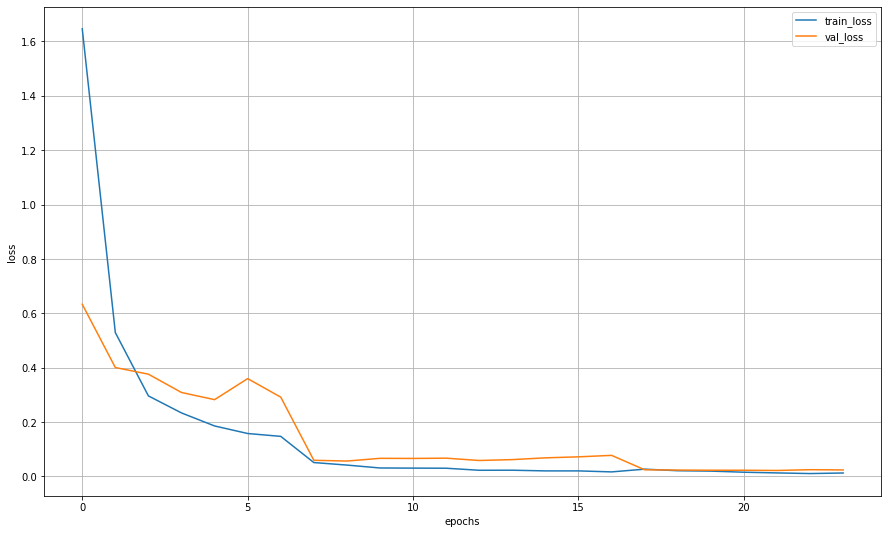

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

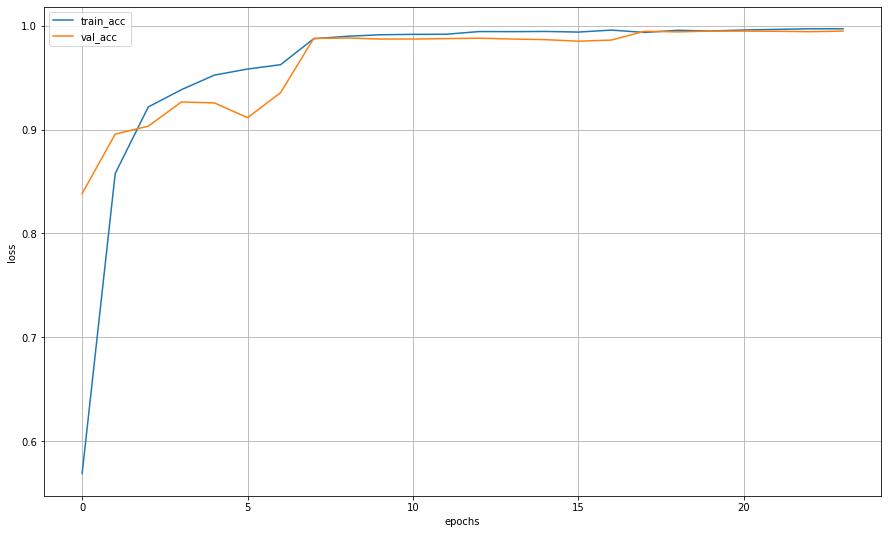

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

##### Submitting

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test", label_encoder=names_encoder)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=256)
probs = predict(model_vgg, test_loader)


preds = names_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
preds[:10]

array(['nelson_muntz', 'bart_simpson', 'ned_flanders', 'chief_wiggum',
       'apu_nahasapeemapetilon', 'kent_brockman', 'edna_krabappel',
       'chief_wiggum', 'lisa_simpson', 'kent_brockman'], dtype='<U24')

In [ ]:
import pandas as pd
# my_submit = pd.read_csv("submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('submission.csv', index=False)